In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/RL')
import sys
import os

# Set the working directory
os.chdir('/content/drive/My Drive/Colab_Notebooks/RL')

# test
from simulator import GlassformSimulator

Mounted at /content/drive


In [3]:
!pip install stable-baselines3[extra]
!pip install 'shimmy>=2.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from simulator import GlassformSimulator

# Load reference data
reference_data = pd.read_csv("reference_table.csv")  # Adjust path

class ParisonControlEnvTgobDisturbance(gym.Env):
    def __init__(self, simulator):
        super(ParisonControlEnvTgobDisturbance, self).__init__()
        self.simulator = simulator
        self.reset()

        # Define action space (adjustments to t_settle, t_counter, t_cooling)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(3,), dtype=np.float32)

        # Define observation space including T_gob_init
        self.observation_space = spaces.Box(
            low=np.array([1100, 966, 374, 2.10 + 1.44, 4.08, 0]),
            high=np.array([1200, 1069, 387, 2.56 + 1.74, 4.82, 100]),
            dtype=np.float32
        )

    def reset(self):
        # Randomly select T_gob_init from the reference table
        selected_row = reference_data.sample(1).iloc[0]
        self.T_gob_init = selected_row["T_gob"]
        self.T_parison_nom = selected_row["T_parison_nom"]
        self.T_mold_nom = selected_row["T_mold_nom"]

        # Reset simulator
        self.simulator.reset(T_mold=self.T_mold_nom)
        self.simulator.T_gob = self.T_gob_init
        self.simulator.T_air = 50
        self.simulator.t_settle = 2.33
        self.simulator.t_counter = 1.59
        self.simulator.t_cooling = 4.45

        # Run initial stabilization cycles
        for _ in range(200):
            self.simulator.simulate_cycle()

        # Apply disturbance
        self.simulator.T_gob += 1
        self.simulator.simulate_cycle()

        self.integral_error = 0  # Reset error accumulation
        self.current_step = 0
        return self._get_observation()

    def step(self, action):
        # Apply RL actions
        self.simulator.t_settle = np.clip(2.33 + action[0] * 0.23, 2.10, 2.56)
        self.simulator.t_counter = np.clip(1.59 + action[1] * 0.15, 1.44, 1.74)
        self.simulator.t_cooling = np.clip(4.45 + action[2] * 0.37, 4.08, 4.82)

        self.simulator.simulate_cycle()
        error = abs(self.simulator.T_parison - self.T_parison_nom)
        self.integral_error = 0.99 * self.integral_error + error
        reward = - (error + 0.01 * self.integral_error)

        done = error < 0.5 or self.current_step >= 200
        self.current_step += 1
        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        return np.array([
            self.simulator.T_gob,
            self.simulator.T_parison,
            self.simulator.T_mold,
            self.simulator.t_settle + self.simulator.t_counter,
            self.simulator.t_cooling,
            self.integral_error
        ], dtype=np.float32)



In [5]:
# Train RL Model
env = make_vec_env(lambda: ParisonControlEnvTgobDisturbance(GlassformSimulator()), n_envs=1)
model = PPO("MlpPolicy", env, ent_coef=0.01, verbose=1)
model.learn(total_timesteps=100000)
model.save("ppo_parison_control_with_tgob_variability")

/usr/local/lib/python3.11/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.23     |
|    ep_rew_mean     | -26.2    |
| time/              |          |
|    fps             | 1297     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 8.13         |
|    ep_rew_mean          | -26.6        |
| time/                   |              |
|    fps                  | 1055         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0075437594 |
|    clip_fraction        | 0.05         |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.24        |
|    explained_variance   | 0.00388      |
|    learning_r

Steady state reached at cycle 96
Steady Parison Temperature: 1048.43°C

Disturbance applied: T_gob increased by 1°C.
Cycle: T_parison = 1047.35, Error = 1.08
Cycle: T_parison = 1047.44, Error = 0.99
Cycle: T_parison = 1047.53, Error = 0.90
Cycle: T_parison = 1047.61, Error = 0.82
Cycle: T_parison = 1047.69, Error = 0.74
Cycle: T_parison = 1047.76, Error = 0.67
Cycle: T_parison = 1047.83, Error = 0.60
Cycle: T_parison = 1047.89, Error = 0.54
Cycle: T_parison = 1047.95, Error = 0.48
Cycle: T_parison = 1048.00, Error = 0.43
Cycle: T_parison = 1048.05, Error = 0.38
Cycle: T_parison = 1048.10, Error = 0.33
Cycle: T_parison = 1048.14, Error = 0.29
✅ System fully stabilized!
Log data saved to parison_control_log.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

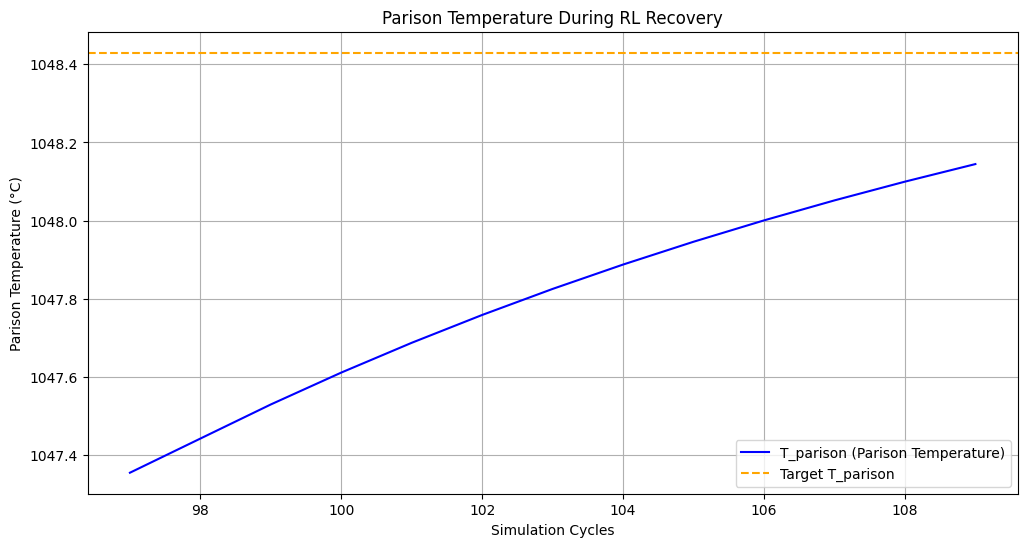

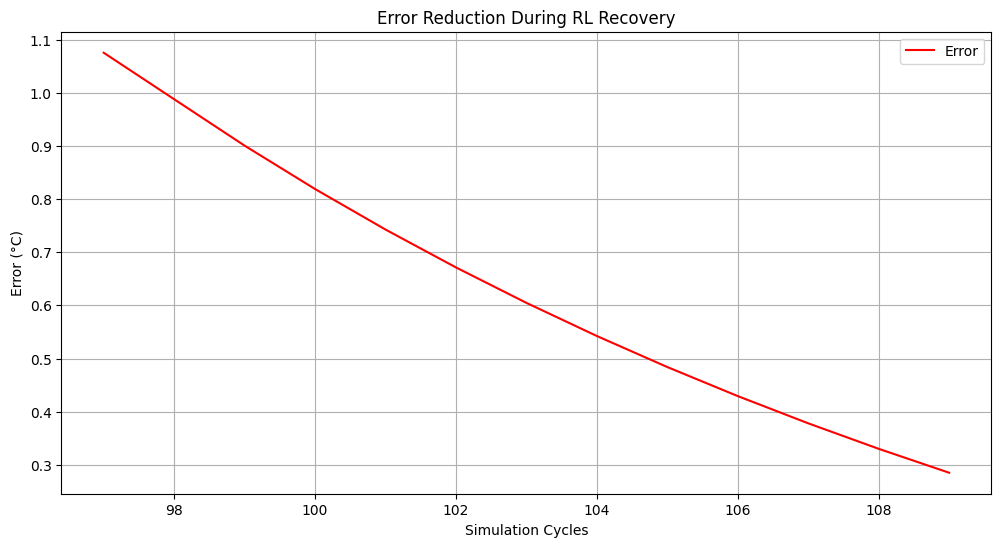

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from simulator import GlassformSimulator

# Load RL Model
model = PPO.load("ppo_parison_control_with_tgob_variability")

# Initialize simulator
simulator = GlassformSimulator()
simulator.reset(T_mold=377.417389538296)  # tHIS VALUE SHOULD BE CHANGED BASED ON THE t_GOB_INIT YOU CHOOSE
simulator.T_gob = 1185  # Initial T_gob from ANY NUMBER FROM 1100 TO 1200
simulator.T_air = 50  # Fixed T_air
simulator.t_settle = 2.33
simulator.t_counter = 1.59
simulator.t_cooling = 4.45

# Detect steady state before applying RL
STEADY_WINDOW = 50
SLOPE_THRESHOLD = 0.01
parison_temps = []
time_steps = []
log_data = []
steady_cycle = None

for i in range(1000):
    simulator.simulate_cycle()
    parison_temps.append(simulator.T_parison)
    time_steps.append(i)

    if i >= STEADY_WINDOW:
        recent_temps = parison_temps[-STEADY_WINDOW:]
        slope = (recent_temps[-1] - recent_temps[0]) / STEADY_WINDOW
        if abs(slope) <= SLOPE_THRESHOLD:
            steady_cycle = i
            print(f"Steady state reached at cycle {steady_cycle}")
            break

if steady_cycle is None:
    print("Steady state not reached within the simulation time.")
    exit()

steady_gob_temp = simulator.T_parison
print(f"Steady Parison Temperature: {steady_gob_temp:.2f}°C")

# Apply disturbance
simulator.T_gob += 1  # Disturbance: Increase T_gob by 1°C
print("\nDisturbance applied: T_gob increased by 1°C.")

# Closed-loop RL control
time_steps = []
gob_temps = []
mold_temps = []
t_contact_values = []
t_cooling_values = []
error_history = []
integral_error = 0

obs = np.array([
    simulator.T_parison,
    simulator.T_mold,
    simulator.t_settle + simulator.t_counter,
    simulator.T_gob,
    simulator.t_cooling,
    integral_error
])

stable_cycles = 0
for i in range(steady_cycle + 1, steady_cycle + 350):
    action, _ = model.predict(obs, deterministic=True)

    simulator.t_settle = np.clip(2.33 + action[0] * 0.23, 2.10, 2.56)
    simulator.t_counter = np.clip(1.59 + action[1] * 0.15, 1.44, 1.74)
    simulator.t_cooling = np.clip(4.45 + action[2] * 0.37, 4.08, 4.82)

    simulator.simulate_cycle()
    gob_temp = simulator.T_parison
    mold_temp = simulator.T_mold
    error = abs(gob_temp - steady_gob_temp)
    integral_error += error

    time_steps.append(i)
    gob_temps.append(gob_temp)
    mold_temps.append(mold_temp)
    t_contact_values.append(simulator.t_settle + simulator.t_counter)
    t_cooling_values.append(simulator.t_cooling)
    error_history.append(error)

    log_data.append({

        "T_parison": gob_temp,
        "T_mold": mold_temp,
        "T_gob": simulator.T_gob,
        "t_contact": simulator.t_settle + simulator.t_counter,
        "t_cooling": simulator.t_cooling,
        "Error": error,
        #"Cycle": i

    })

    print(f"Cycle: T_parison = {gob_temp:.2f}, Error = {error:.2f}")

    if error < 0.5:
        stable_cycles += 1
    else:
        stable_cycles = 0  # Reset stable count if error increases

    if stable_cycles >= 5:
        print(f"✅ System fully stabilized!")
        break

    obs = np.array([
        gob_temp, simulator.T_mold, simulator.t_settle + simulator.t_counter,
        simulator.T_gob, simulator.t_cooling, integral_error
    ])

# Save log data to CSV
log_df = pd.DataFrame(log_data)
log_file = "parison_control_log.csv"
log_df.to_csv(log_file, index=False)
print(f"Log data saved to {log_file}")

# Automatically download the log file
from google.colab import files
files.download(log_file)

# Plot Parison Temperature
plt.figure(figsize=(12, 6))
plt.plot(time_steps, gob_temps, label="T_parison (Parison Temperature)", color="blue")
plt.axhline(y=steady_gob_temp, color="orange", linestyle="--", label="Target T_parison")
plt.xlabel("Simulation Cycles")
plt.ylabel("Parison Temperature (°C)")
plt.title("Parison Temperature During RL Recovery")
plt.legend()
plt.grid(True)
plt.show()

# Plot Error History
plt.figure(figsize=(12, 6))
plt.plot(time_steps, error_history, label="Error", color="red")
plt.xlabel("Simulation Cycles")
plt.ylabel("Error (°C)")
plt.title("Error Reduction During RL Recovery")
plt.legend()
plt.grid(True)
plt.show()